# 인공지능 작사가 만들기


### 순환신경망**(RNN)**

---

1. **단어 예측**

"나는 밥을 [ ]." [ ]에 들어올 수 단어는??  
먹었다. 먹는다 → 동사가 들어올 것을 예측할 수 있게 수 많은 글을 읽게 해서 인식하게 함

<br>

2.그럼 “**나는**” 이라는 단어는 어떻게 생성되는가? 

**\<start>**라는 특수한 토큰을 맨 앞에 추가해 줌으로써 해결 가능 → 인공지능에게 사인 주기

\<start>를 입력으로 받은 순환신경망은 다음 단어로 "나는”을 생성하고, 생성한 단어를 다시 입력으로 사용

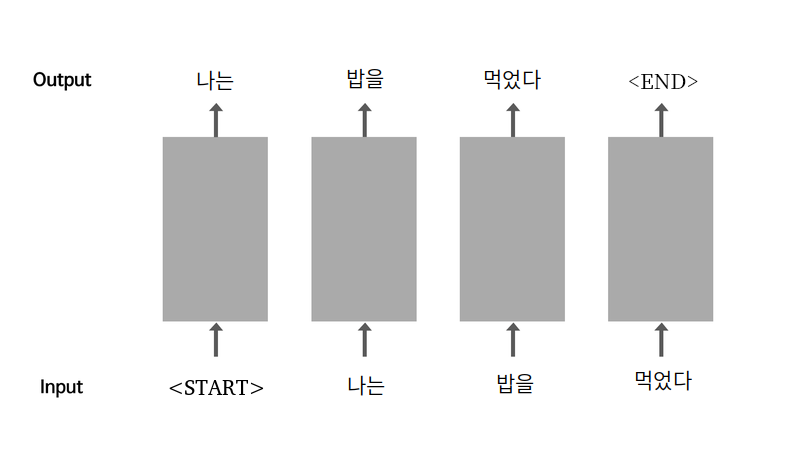 

<br><br>
    
### **언어 모델 (Language Model)**

---

 **문구 뒤에 어떤 단어가 나올 확률이 높다는 것은 그 단어가 나오는 것이 보다 자연스럽다는 뜻**
    - **'나는 밥을' 다음에 '먹었다' 가 나올 확률 : a**
    - **'나는' 뒤에 '밥이' 가 나올 확률 : b**
    - **‘나는 밥을 맛있게’ 뒤에 ‘먹었다’가 나올 확률 : c**
    
    → a, b, c의 확률이 서로 다른 데 높은 확률이 출력되게 연습하는 것이 잘 학습된 언어 모델은 훌륭한 문장 생성기로 동작하기 위한 기초

# Test1 
#### 훈련, 검증, 테스트 세트 분리하기
- 검증이 필요한 것 같아서 검증세트까지 분리 -> 하지만 쓸 일이 없다...
#### batch_size=128, hidden_size=2048
- hidden_size를 늘이니 매우 시간이 오래걸린다.
- 한 에폭당 245초 정도 걸리니.. 약 40분이상 소요.. ㅜ.ㅜ

### 1. 필요한 라이브러리 불러오기

In [33]:
import glob, os, re
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

### 2. 데이터 가져오기

In [2]:
# 데이터 가져오기
txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담기
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?"]


### 3. 정규표현식을 이용한 정제함수 만들기

1. .lower().strip()을 이용해서 소문자로 바꾸고, 양쪽 공백 지우기  
2. re.sub(r"([?.!,¿])", r" \1 ", sentence) : 특수문자 양쪽에 공백 넣기  
3. re.sub(r'[" "]+', " ", sentence) : 여러 개의 공백을 하나의 공백으로 대체  
4. re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) : a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꾸기  
5. sentence.strip() : 다시 양쪽 공백 지우기
6. '\<start>' + sentence + ' \<end>' : 문장 시작에는 \<start>, 끝에는 \<end>를 추가하기

In [3]:
# 정제함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence


### 4. 정제함수를 이용해 정제 말뭉치 만들기

In [4]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    
    # 토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장 건너뛰기
    if len(preprocessed_sentence.split()) > 15: continue
        
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 5개만 확인하기
corpus[:5]

['<start> now i ve heard there was a secret chord <end>',
 '<start> that david played , and it pleased the lord <end>',
 '<start> but you don t really care for music , do you ? <end>',
 '<start> it goes like this <end>',
 '<start> the fourth , the fifth <end>',
 '<start> the minor fall , the major lift <end>',
 '<start> the baffled king composing hallelujah hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah your faith was strong but you needed proof <end>']

### 5. 벡터화

- 12000단어를 기억할 수 있는 tokenizer를 만들기
- 12000단어에 포함되지 못한 단어는 '\<unk>'로 바꾸기
- 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용
   - 문장이 짧을 때 '0'으로 padding해서 문장 길이 맞추기
   - 'post'는 문장 뒤에 '0' 붙이기

In [5]:
# 토근화 함수 만들기
def tokenize(corpus):   
   
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )

    # corpus를 이용해 tokenizer 내부의 단어장을 완성
    tokenizer.fit_on_texts(corpus)

    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환
    tensor = tokenizer.texts_to_sequences(corpus)   

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print("tensor\n", tensor)
    print("tokenizer :\n", tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

tensor
 [[   2   50    4 ...    0    0    0]
 [   2   15 2967 ...    0    0    0]
 [   2   33    7 ...   46    3    0]
 ...
 [   2    4  118 ...    0    0    0]
 [   2  258  194 ...   12    3    0]
 [   2    7   34 ...    0    0    0]]
tokenizer :


In [6]:
# 그냥 벡터화 한 tensor의 크기가 궁금해서
print(tensor.shape)

(156013, 15)


In [7]:
# 단어사전보기
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break


1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


## 7. 텐서를 소스와 타겟으로 분리

In [8]:
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print("소스 문장 5줄 tensor\n", src_input[:5], "\n")
print("타겟 문장 5줄 tensor\n", tgt_input[:5])

소스 문장 5줄 tensor
 [[   2   50    4   95  303   62   53    9  946 6263    3    0    0    0]
 [   2   15 2967  871    5    8   11 5739    6  374    3    0    0    0]
 [   2   33    7   40   16  164  288   28  333    5   48    7   46    3]
 [   2   11  335   23   41    3    0    0    0    0    0    0    0    0]
 [   2    6 4486    5    6 2039    3    0    0    0    0    0    0    0]] 

타겟 문장 5줄 tensor
 [[  50    4   95  303   62   53    9  946 6263    3    0    0    0    0]
 [  15 2967  871    5    8   11 5739    6  374    3    0    0    0    0]
 [  33    7   40   16  164  288   28  333    5   48    7   46    3    0]
 [  11  335   23   41    3    0    0    0    0    0    0    0    0    0]
 [   6 4486    5    6 2039    3    0    0    0    0    0    0    0    0]]


## 8. 훈련 , 검증 , 테스트 데이터 분리

In [42]:
from sklearn.model_selection import train_test_split

# 훈련, 테스트 세트 분리
enc_total, enc_test, dec_total, dec_test = train_test_split(src_input, tgt_input, test_size=0.2, random_state=42)
# 훈련, 검증세트 분리
enc_train, enc_val, dec_train, dec_val = train_test_split(enc_total, dec_total, test_size=0.125, random_state=42)

In [43]:
# 훈련, 검증, 테스트 데이터셋 구조 보기
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)
print("Source Validation:", enc_val.shape)
print("Target Validation:", dec_val.shape)
print("Source Test:", enc_test.shape)
print("Target Test:", dec_test.shape)

Source Train: (109208, 14)
Target Train: (109208, 14)
Source Validation: (15602, 14)
Target Validation: (15602, 14)
Source Test: (31203, 14)
Target Test: (31203, 14)


### 9. 모델 만들기

In [48]:
# 모델 만들기
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

### 10. 훈련하기

In [50]:
# 모델 컴파일
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)


In [51]:
# 모델 훈련하기
hist = model.fit(enc_train, dec_train, epochs=10, batch_size=128, 
                 validation_data=(enc_val, dec_val))                

Epoch 1/10
854/854 [==============================] - 235s 253ms/step - loss: 3.2147 - val_loss: 2.8597
Epoch 2/10
854/854 [==============================] - 225s 263ms/step - loss: 2.6771 - val_loss: 2.6060
Epoch 3/10
854/854 [==============================] - 225s 264ms/step - loss: 2.3060 - val_loss: 2.4295
Epoch 4/10
854/854 [==============================] - 226s 265ms/step - loss: 1.9445 - val_loss: 2.3182
Epoch 5/10
854/854 [==============================] - 226s 265ms/step - loss: 1.6307 - val_loss: 2.2583
Epoch 6/10
854/854 [==============================] - 226s 264ms/step - loss: 1.3872 - val_loss: 2.2441
Epoch 7/10
854/854 [==============================] - 227s 265ms/step - loss: 1.2117 - val_loss: 2.2617
Epoch 8/10
854/854 [==============================] - 227s 265ms/step - loss: 1.1048 - val_loss: 2.2873
Epoch 9/10
854/854 [==============================] - 227s 265ms/step - loss: 1.0471 - val_loss: 2.3192
Epoch 10/10
854/854 [==============================] - 227s 265m

### 11. 손실함수 시각화

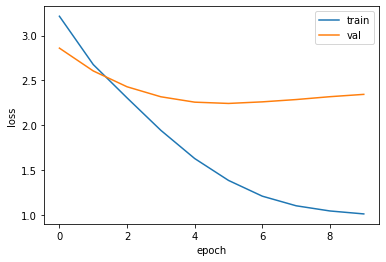

In [52]:
# 손실함수 그리기
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### 12. 문자 생성 함수 만들기, 문자 생성 함수 실행

In [53]:
# 문자 생성 함수 만들기
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [54]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , oh , yeah <end> '

# Test2
### hidden_size = 2048, random_state=7, batch_size=1024
#### batch_size가 1024이니 검증세트가 다시 올라가지는 않는다.
#### 하지만 아직도 val_loss가 엉망이다..

### 훈련, 테스트 세트만 분리

## 8. 훈련 , 검증 , 테스트 데이터 분리

In [14]:
from sklearn.model_selection import train_test_split

# 훈련, 테스트 세트 분리
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=32)

In [15]:
# 훈련, 검증, 테스트 데이터셋 구조 보기
print("Source Test:", enc_train.shape)
print("Target Test:", dec_train.shape)
print("Source Validation:", enc_val.shape)
print("Target Validation:", dec_val.shape)

Source Test: (124810, 14)
Target Test: (124810, 14)
Source Validation: (31203, 14)
Target Validation: (31203, 14)


## 9. 모델 만들기

In [24]:
# 모델 만들기
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

## 10. 훈련하기

In [12]:
# model.summary()

In [25]:
# 모델 컴파일
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)

In [26]:
# 모델 훈련하기
hist = model.fit(x = enc_train, y = dec_train, epochs=10, batch_size=1024, validation_data=(enc_val, dec_val))                

Epoch 1/10
122/122 [==============================] - 110s 869ms/step - loss: 4.0773 - val_loss: 3.4482
Epoch 2/10
122/122 [==============================] - 105s 862ms/step - loss: 3.3410 - val_loss: 3.2566
Epoch 3/10
122/122 [==============================] - 105s 864ms/step - loss: 3.1695 - val_loss: 3.1303
Epoch 4/10
122/122 [==============================] - 105s 863ms/step - loss: 3.0629 - val_loss: 3.0505
Epoch 5/10
122/122 [==============================] - 105s 865ms/step - loss: 2.9817 - val_loss: 2.9876
Epoch 6/10
122/122 [==============================] - 105s 864ms/step - loss: 2.9118 - val_loss: 2.9318
Epoch 7/10
122/122 [==============================] - 105s 865ms/step - loss: 2.8488 - val_loss: 2.8869
Epoch 8/10
122/122 [==============================] - 105s 865ms/step - loss: 2.7931 - val_loss: 2.8474
Epoch 9/10
122/122 [==============================] - 106s 865ms/step - loss: 2.7405 - val_loss: 2.8122
Epoch 10/10
122/122 [==============================] - 106s 866m

## 11. 손실함수 시각화

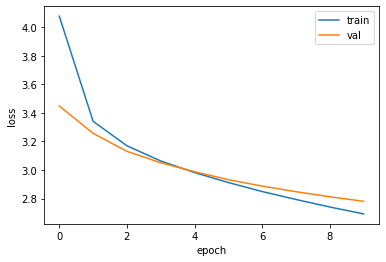

In [27]:
# 손실함수 그리기
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### 12. 문자 생성 함수 만들기, 문자 생성 함수 실행

In [28]:
# 문자 생성 함수 만들기
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [29]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i m gonna be a <unk> <end> '

# Test3
#### 과적합이 되면서 val_loss가 내려가다가 다시 올라가서 drop_out을 추가했다.
#### batch_size가 val_loss를 잡아주는 것 같아서 주었는 데.. drop_out을 추가해서 삭제 후 다시 훈련
#### 훈련에 들이는 시간에 비해서 아직도 2.2가 되지를 않는다... ㅜ.ㅜ
## dropout(0.5)추가 hidden=1024

In [33]:
# 모델 만들기
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.drop = tf.keras.layers.Dropout(0.5)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.drop(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [34]:
# 모델 컴파일
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)

# 모델 훈련하기
hist = model.fit(x = enc_train, y = dec_train, epochs=10, validation_data=(enc_val, dec_val)) 

Epoch 1/10
3901/3901 [==============================] - 145s 36ms/step - loss: 3.1574 - val_loss: 2.9043
Epoch 2/10
3901/3901 [==============================] - 140s 36ms/step - loss: 2.8244 - val_loss: 2.7291
Epoch 3/10
3901/3901 [==============================] - 140s 36ms/step - loss: 2.6370 - val_loss: 2.6062
Epoch 4/10
3901/3901 [==============================] - 140s 36ms/step - loss: 2.4666 - val_loss: 2.5054
Epoch 5/10
3901/3901 [==============================] - 140s 36ms/step - loss: 2.3099 - val_loss: 2.4342
Epoch 6/10
3901/3901 [==============================] - 140s 36ms/step - loss: 2.1662 - val_loss: 2.3839
Epoch 7/10
3901/3901 [==============================] - 140s 36ms/step - loss: 2.0406 - val_loss: 2.3496
Epoch 8/10
3901/3901 [==============================] - 140s 36ms/step - loss: 1.9335 - val_loss: 2.3234
Epoch 9/10
3901/3901 [==============================] - 140s 36ms/step - loss: 1.8415 - val_loss: 2.3045
Epoch 10/10
3901/3901 [==============================] 

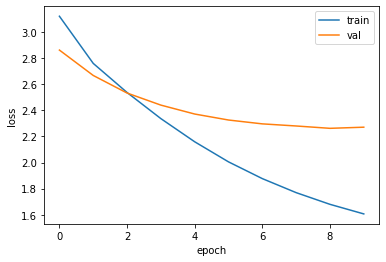

In [18]:
# 손실함수 그리기
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### 문자 생성 함수 만들기, 문자 생성 함수 실행

In [19]:
# 문자 생성 함수 만들기
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [36]:
# 문자 생성해보기
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i love you <end> '

# Test4
## dropout(0.5)추가 hidden=2048
#### dropout(0.4)를 하니 val_loss가 기준에 맞춰지지를 않아서, hidden_size를 조정했다..
#### 드디어 val_loss가 2.2이하가 됐다..
#### 수치는 만족스럽지 않지만 이제 끝이다.. 행복해 할거다.....

In [20]:
# 모델 만들기
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.drop = tf.keras.layers.Dropout(0.5)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.drop(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [21]:
# 모델 컴파일
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)

# 모델 훈련하기
hist = model.fit(x = enc_train, y = dec_train, epochs=10, validation_data=(enc_val, dec_val)) 

Epoch 1/10
3901/3901 [==============================] - 429s 105ms/step - loss: 3.0946 - val_loss: 2.8110
Epoch 2/10
3901/3901 [==============================] - 411s 105ms/step - loss: 2.7045 - val_loss: 2.5900
Epoch 3/10
3901/3901 [==============================] - 411s 105ms/step - loss: 2.4426 - val_loss: 2.4429
Epoch 4/10
3901/3901 [==============================] - 411s 105ms/step - loss: 2.1979 - val_loss: 2.3304
Epoch 5/10
3901/3901 [==============================] - 411s 105ms/step - loss: 1.9875 - val_loss: 2.2562
Epoch 6/10
3901/3901 [==============================] - 411s 105ms/step - loss: 1.8173 - val_loss: 2.2116
Epoch 7/10
3901/3901 [==============================] - 412s 106ms/step - loss: 1.6829 - val_loss: 2.1954
Epoch 8/10
3901/3901 [==============================] - 411s 105ms/step - loss: 1.5787 - val_loss: 2.1808
Epoch 9/10
3901/3901 [==============================] - 411s 105ms/step - loss: 1.5020 - val_loss: 2.1869
Epoch 10/10
3901/3901 [=======================

In [22]:
model.summary()

Model: "text_generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  3072256   
_________________________________________________________________
lstm_2 (LSTM)                multiple                  18882560  
_________________________________________________________________
lstm_3 (LSTM)                multiple                  33562624  
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  24590049  
Total params: 80,107,489
Trainable params: 80,107,489
Non-trainable params: 0
_________________________________________________________________


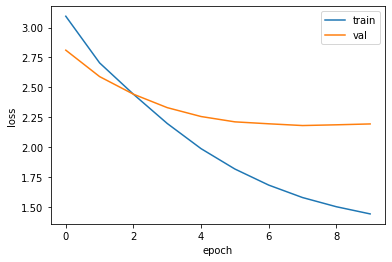

In [23]:
# 손실함수 그리기
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [24]:
# 문자 생성 함수 만들기
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [28]:
# 문자 생성해보기
print(generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20))
print(generate_text(model, tokenizer, init_sentence="<start> finally ", max_len=20))
print(generate_text(model, tokenizer, init_sentence="<start> end ", max_len=20))
print(generate_text(model, tokenizer, init_sentence="<start> happy ", max_len=20))
print(generate_text(model, tokenizer, init_sentence="<start> home ", max_len=20))

<start> i love you , i love you <end> 
<start> finally i m free , but i m not leaving , no ! <end> 
<start> end up and <unk> , you re breaking on <end> 
<start> happy birthday , happy birthday , happy birthday woo , shake ! <end> 
<start> home and <unk> <end> 


# 회고

### 1. 이번 프로젝트에서 어려웠던 점
#### 검증세트를 만들지 않고 훈련해서 loss가 1점대가 나와서 이제 끝났구나...
#### 알고보니 검증세트를 넣지 않고 해서.. val_loss가 없다..
#### 훈련시간이 너무 많이 걸려서 힘들었다..

### 2. 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
#### batch_size가 과적합을 막아주는 것 같았다.
#### Aiffel server에서 할 때는 txt파일이 잘 읽어졌는 데.. 내 컴퓨터로 하니 읽어들이지 못한다....
#### 윈도우 환경에서 txt파일 읽어들이는 것을 알게 되었다. 무식하게 했는 데 더 쉬운 방법이 있어서... ㅜ.ㅜ
#### 딥러닝에서 과적합의 적은 "dropout"이라는 것을 알게 되었다. 물론 완벽하지는 않다.

### 3. 루브릭 평가 지표를 맞추기 위해 시도한 것들
#### 조원들의 도움으로 정제를 편하게 해서 이번 과제는 쉽겠구나.. 아니~~ 이런 뒷통수라니...
#### hidden_size 조정, batch_size조정, 훈련세트 재구성, DropOut를 넣기
#### 여기에는 4개의 테스트밖에 없지만, 무수히 많은 훈련을 하고 또 했어요~ !! 아~  힘들어요!!

### 4.  자기다짐
#### 생각만 하지 말고 직접하자!!!! DropOut을 생각했으나 그냥 지나쳐서 많은 시간을 버렸다..
#### 고민하지 말고 필요하다고 생각하면 바로 시행하기

In [ ]:
- 회고**(필수)**
    
    프로젝트 마지막에는 항상 프로젝트에 대한 회고를 기록합니다. 
    
    회고에는 다음과 같은 것들이 포함됩니다.
    
    - 이번 프로젝트에서 **어려웠던 점,**
    - 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
    - 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
    - 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
    - **자기 다짐**